**3.A**

Cara kerjanya kita pakai analogi polisi dan penjahat untuk arsitektur ini. Penjahat sebagai generator dan polisi sebagai discriminator. Nah si penjahat itu akan generate fake image dari random noise yang ada. Polisi tugasnya adalah menentukan image tersebut real or fake. 

Polisi harus terus menerut latihan dan belajar untuk menentukan image-image yang ada itu real atau fake dengan training data set yang ada, si penjahat juga berlatih dalam membuat generator yang bisa generate gambar sereal mungkin.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import preprocessing
from keras.models import Sequential
from keras.layers import Conv2D,Dropout,Dense,Flatten,Conv2DTranspose,BatchNormalization,LeakyReLU,Reshape
import tensorflow as tf

In [2]:
from tensorflow.keras.datasets import fashion_mnist
import tensorflow as tf
import matplotlib.pyplot as plt

(data_train, label_train), (data_test, label_test) = fashion_mnist.load_data()

data_train = data_train.astype('float32') / 255.
data_test = data_test.astype('float32') / 255.


data = tf.concat([data_train, data_test], axis= 0)
label = tf.concat([label_train, label_test], axis= 0)

indices = tf.squeeze(tf.where(tf.logical_or(tf.equal(label, 4), tf.equal(label, 5))))
data = tf.gather(data, indices)
label = tf.gather(label, indices)

print(label.shape)
print(data.shape)

(14000,)
(14000, 28, 28)


In [3]:
data = tf.reshape(data, shape=(data.shape[0], -1))


In [4]:
df = pd.DataFrame(data.numpy())
label = label.numpy()
df.head()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007843,0.0,0.0,...,0.235294,0.219608,0.262745,0.086275,0.0,0.007843,0.0,0.0,0.0,0.0


In [5]:
df_label = pd.DataFrame(label)
df_label

,0
0,5
1,5
2,5
3,5
4,4
...,...
13995,5
13996,5
13997,4
13998,5


In [6]:
X_train = df
X_train = X_train.values
print(X_train.shape)

(14000, 784)


Melakukan normalisasi ulang pada X_train. Setelah data dinormalisasi, data tersebut dikalikan dengan 2 dan kemudian dikurangi 1 sehingga nilainya berada dalam rentang (-1, 1). Hal ini dilakukan karena dalam DCGANs, lapisan aktivasi terakhir dari model generatif menggunakan fungsi tanh yang memiliki rentang output (-1, 1), berbeda dengan sigmoid yang memiliki rentang (0, 1).

In [10]:
X_train=X_train.reshape(-1,28,28,1)
X_train =  X_train.astype('float32')
X_train = X_train/255
X_train = X_train*2 - 1.
print(X_train.shape)

(14000, 28, 28, 1)


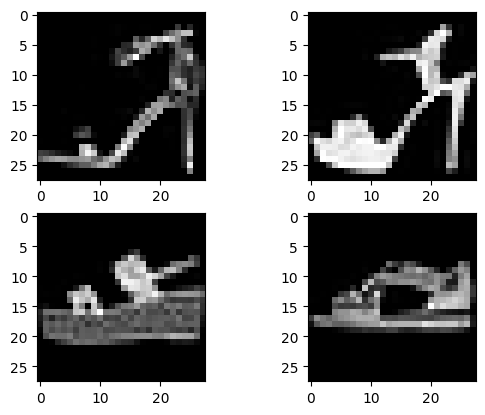

In [8]:
fig,axe=plt.subplots(2,2)
idx = 0
for i in range(2):
    for j in range(2):
        axe[i,j].imshow(X_train[idx].reshape(28,28),cmap='gray')
        idx+=1

In [12]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Reshape, LeakyReLU, BatchNormalization, Embedding, Input, Flatten
import tensorflow as tf

# Define Generator
generator = Sequential([
    Dense(1024, input_shape = [100]),
    LeakyReLU(alpha=0.2),
    BatchNormalization(momentum=0.8),
    Dense(512),
    LeakyReLU(alpha=0.2),
    BatchNormalization(momentum=0.8),
    Dense(256),
    LeakyReLU(alpha=0.2),
    BatchNormalization(momentum=0.8),
    Dense(128),
    LeakyReLU(alpha=0.2),
    BatchNormalization(momentum=0.8),
    Dense(784, activation='sigmoid'),
    Reshape([28, 28, 1])
])

generator.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              103424    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 1024)              0         
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 512)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                        

In [13]:
# Define Discriminator
discriminator = Sequential([
    Dense(1, input_shape=[28, 28, 1]),
    Flatten(),
    Dense(512),
    LeakyReLU(alpha=0.2),
    Dense(1024),
    LeakyReLU(alpha=0.2),
    Dense(512),
    LeakyReLU(alpha=0.2),
    Dense(1, activation='sigmoid')
])

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 28, 28, 1)         2         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_6 (Dense)             (None, 512)               401920    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 1024)              525312    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 1024)              0         
                                                                 
 dense_8 (Dense)             (None, 512)              

In [16]:
model = Sequential([generator,discriminator])
discriminator.compile(optimizer='adam',loss='binary_crossentropy')
discriminator.trainable = False

In [19]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy')

In [20]:
model.layers

In [21]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 28, 28, 1)         901264    
                                                                 
 sequential_1 (Sequential)   (None, 1)                 1452547   
                                                                 
Total params: 2,353,811
Trainable params: 897,424
Non-trainable params: 1,456,387
_________________________________________________________________


In [22]:
epochs = 30
batch_size = 100
noise_shape=100

Currently on Epoch 1
	Currently on batch number 50 of 140
	Currently on batch number 100 of 140


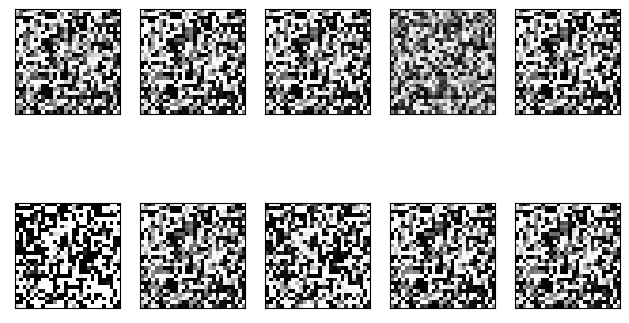

Currently on Epoch 2
	Currently on batch number 50 of 140
	Currently on batch number 100 of 140
Currently on Epoch 3
	Currently on batch number 50 of 140
	Currently on batch number 100 of 140
Currently on Epoch 4
	Currently on batch number 50 of 140
	Currently on batch number 100 of 140
Currently on Epoch 5
	Currently on batch number 50 of 140
	Currently on batch number 100 of 140
Currently on Epoch 6
	Currently on batch number 50 of 140
	Currently on batch number 100 of 140
Currently on Epoch 7
	Currently on batch number 50 of 140
	Currently on batch number 100 of 140
Currently on Epoch 8
	Currently on batch number 50 of 140
	Currently on batch number 100 of 140
Currently on Epoch 9
	Currently on batch number 50 of 140
	Currently on batch number 100 of 140
Currently on Epoch 10
	Currently on batch number 50 of 140
	Currently on batch number 100 of 140
Currently on Epoch 11
	Currently on batch number 50 of 140
	Currently on batch number 100 of 140


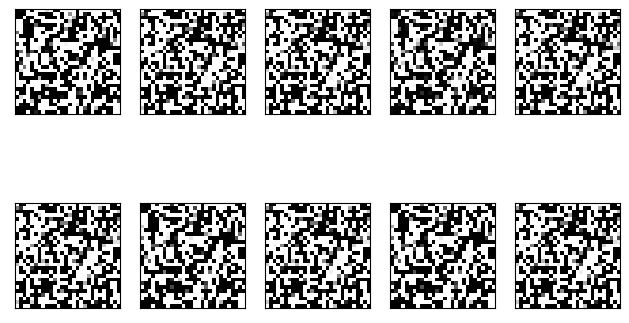

Currently on Epoch 12
	Currently on batch number 50 of 140
	Currently on batch number 100 of 140
Currently on Epoch 13
	Currently on batch number 50 of 140
	Currently on batch number 100 of 140
Currently on Epoch 14
	Currently on batch number 50 of 140
	Currently on batch number 100 of 140
Currently on Epoch 15
	Currently on batch number 50 of 140
	Currently on batch number 100 of 140
Currently on Epoch 16
	Currently on batch number 50 of 140
	Currently on batch number 100 of 140
Currently on Epoch 17
	Currently on batch number 50 of 140
	Currently on batch number 100 of 140
Currently on Epoch 18
	Currently on batch number 50 of 140
	Currently on batch number 100 of 140
Currently on Epoch 19
	Currently on batch number 50 of 140
	Currently on batch number 100 of 140
Currently on Epoch 20
	Currently on batch number 50 of 140
	Currently on batch number 100 of 140
Currently on Epoch 21
	Currently on batch number 50 of 140
	Currently on batch number 100 of 140


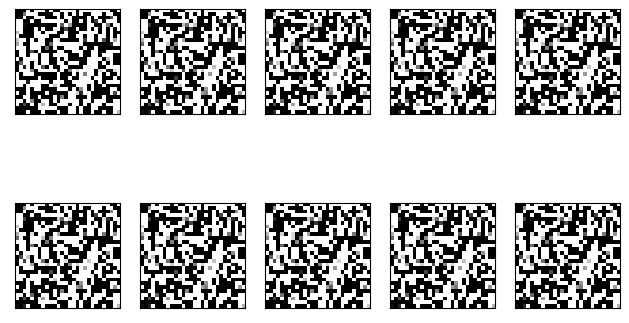

Currently on Epoch 22
	Currently on batch number 50 of 140
	Currently on batch number 100 of 140
Currently on Epoch 23
	Currently on batch number 50 of 140
	Currently on batch number 100 of 140
Currently on Epoch 24
	Currently on batch number 50 of 140
	Currently on batch number 100 of 140
Currently on Epoch 25
	Currently on batch number 50 of 140
	Currently on batch number 100 of 140
Currently on Epoch 26
	Currently on batch number 50 of 140
	Currently on batch number 100 of 140
Currently on Epoch 27
	Currently on batch number 50 of 140
	Currently on batch number 100 of 140
Currently on Epoch 28
	Currently on batch number 50 of 140
	Currently on batch number 100 of 140
Currently on Epoch 29
	Currently on batch number 50 of 140
	Currently on batch number 100 of 140
Currently on Epoch 30
	Currently on batch number 50 of 140
	Currently on batch number 100 of 140
Training is complete


In [24]:
with tf.device('/gpu:0'):
 for epoch in range(epochs):
    print(f"Currently on Epoch {epoch+1}")
    
    
    for i in range(X_train.shape[0]//batch_size):
        
        if (i+1)%50 == 0:
            print(f"\tCurrently on batch number {i+1} of {X_train.shape[0]//batch_size}")
            
        noise=np.random.normal(size=[batch_size,noise_shape])
       
        gen_image = generator.predict_on_batch(noise)
        
        train_dataset = X_train[i*batch_size:(i+1)*batch_size]
       
        #training discriminator on real images
        train_label=np.ones(shape=(batch_size,1))
        discriminator.trainable = True
        d_loss_real=discriminator.train_on_batch(train_dataset,train_label)
        
        #training discriminator on fake images
        train_label=np.zeros(shape=(batch_size,1))
        d_loss_fake=discriminator.train_on_batch(gen_image,train_label)
        
        
        #training generator 
        noise=np.random.normal(size=[batch_size,noise_shape])
        train_label=np.ones(shape=(batch_size,1))
        discriminator.trainable = False
        
        d_g_loss_batch = model.train_on_batch(noise, train_label)
        
        
        
       
    #plotting generated images at the start and then after every 10 epoch
    if epoch % 10 == 0:
        samples = 10
        x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples, 100)))

        for k in range(samples):
            plt.subplot(2, 5, k+1)
            plt.imshow(x_fake[k].reshape(28, 28), cmap='gray')
            plt.xticks([])
            plt.yticks([])

        plt.tight_layout()
        plt.show()

        
        
print('Training is complete')

In [25]:
noise=np.random.normal(size=[10,noise_shape])

gen_image = generator.predict(noise)

Text(0.5, 1.0, 'How the noise looks')

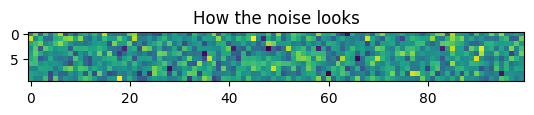

In [26]:
plt.imshow(noise)
plt.title('How the noise looks')

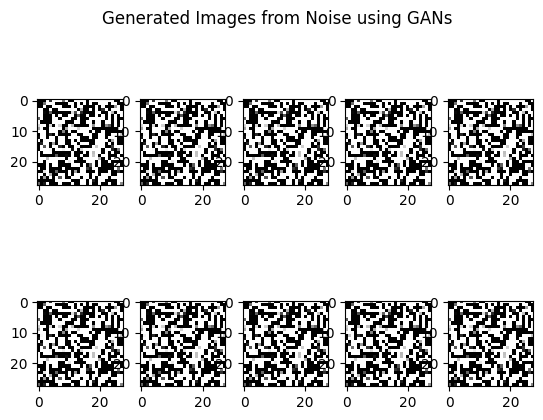

In [27]:
fig,axe=plt.subplots(2,5)
fig.suptitle('Generated Images from Noise using GANs')
idx=0
for i in range(2):
    for j in range(5):
         axe[i,j].imshow(gen_image[idx].reshape(28,28),cmap='gray')
         idx+=1

In [28]:
noise=np.random.normal(loc=0, scale=1, size=(100,noise_shape))

gen_image = generator.predict(noise)

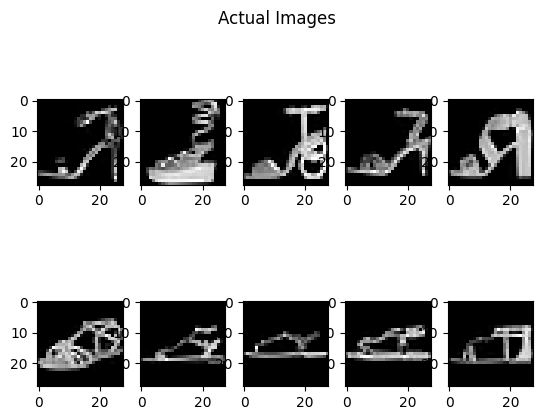

In [29]:
fig,axe=plt.subplots(2,5)
fig.suptitle("Actual Images")
idx = 0
for i in range(2):
    for j in range(5):
        axe[i,j].imshow(X_train[idx].reshape(28,28),cmap='gray')
        idx+=10

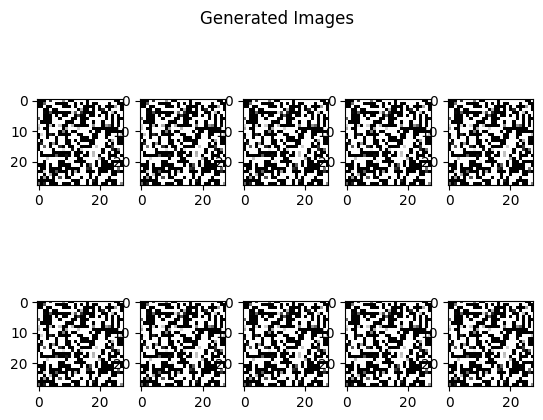

In [31]:
fig,axe=plt.subplots(2,5)
fig.suptitle('Generated Images')
idx=0
for i in range(2):
     for j in range(5):
         axe[i,j].imshow(gen_image[idx].reshape(28,28),cmap='gray')
         idx+=3